# Getting Started

## Overview

This notebook shows how a non-negative, monotone function $\mu(x)$, which we will call a "measure", can be approximated using moments, and how the approximation can be differentiated.

In particular, you will learn about the key functions exposed by the `diffmoments` package.

## Setup

Start by importing packages required by this notebook.

In [1]:
import matplotlib.pyplot as plt
import torch

## Defining a Measure

A measure $\mu(x)$ can be defined by its non-negative differential $\text{d} \mu(x)$, such that $\mu(x) = \int\limits_{-\infty}^{x} \text{d} \mu(x)$.

For the sake of simplicity, we assume that $\text{d} \mu(x) = f(x) \, \text{d} x$, so the measure is defined by a non-negative function $f$, which we will call "density".

For this tutorial, we model $f$ as the sum of $N$ (scaled) Gaussians: $f(x) = \sum\limits_{i = 1}^{N} \text{scale}_i  \exp(-\frac{(x - \text{mean}_i)^2}{2\text{variance}_i}) $. 

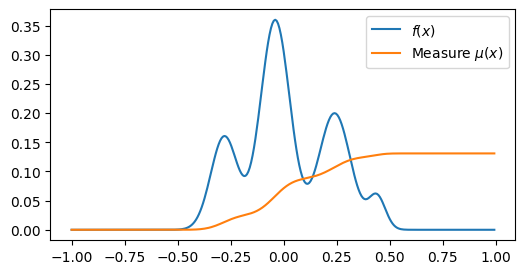

In [2]:
def sum_of_gaussians(x: torch.Tensor, mean: torch.Tensor, variance: torch.Tensor, scale: torch.Tensor):
    """ 
    Evaluate a sum of Gaussians, 

    Parameters
    ----------
        x : torch.Tensor
            Evaluation points, as array of shape (B)
        mean : torch.Tensor
            Means of the Gaussians, as array of shape (N)
        variance : torch.Tensor
            Variance of the Gaussians, as array of shape (N)
        scale : torch.Tensor
            Scale of the Gaussians, as array of shape (N)
    """
    return (scale[None, :] * torch.exp(-(x[:, None] - mean[None, :])**2 / (2*variance[None, :]))).sum(-1)

def integrate(f: callable, lower: int, upper: int, n: int, cumulative: bool = False, return_x: bool = False):
    """ 
    Numerically integrate a function f over the interval [lower, upper] using the rectangle rule.

    Parameters
    ----------
    f : callable
        The function to integrate. It should take a 1D array as input and return a 1D (scalar-valued) or 2D (vector-valued) array.
    lower : int
        The lower limit of integration.
    upper : int
        The upper limit of integration.
    n : int
        The number of intervals to use in the rectangle rule.
    cumulative : bool, optional
        If True, return the cumulative integral at each point. If False, return the total integral. Default is False.
    return_x : bool, optional
        If True, also return the x values used for the integration. Default is False.
    """

    x = torch.linspace(lower, upper, n + 1)
    
    dx = x[1:] - x[:-1]

    y = f(x[:-1])
    if y.ndim == 0 or y.ndim > 2:
        raise ValueError("The function f must return a 1D or 2D tensor.")

    # Expand dx to the same shape as y, which can be vector-valued (but not necessarily)
    dx = dx[:, None] if y.ndim > 1 else dx

    result = torch.cumsum(dx * y, dim=0) if cumulative else torch.sum(dx * y, dim=0)
    return (result, x[:-1]) if return_x else result

# Use a sum of Gaussians (non-negative) to define the measure μ 
factor    = 0.8
mean      = factor*torch.tensor([-0.35, -0.05, 0.3, 0.55])
variance  = factor*torch.tensor([0.005, 0.006, 0.007, 0.002])
scale     = factor*torch.tensor([0.2, 0.45, 0.25, 0.07])   
f = lambda x: sum_of_gaussians(x, mean, variance, scale)

# Set the lower and upper limits of the domain
# (assuming the interval includes the support of f)
lower_limit = -1
upper_limit =  1

# Integrate f(x) numerically to obtain μ(x)
μ_at_x, x = integrate(f, lower_limit, upper_limit, 300, cumulative=True, return_x=True)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(x, f(x), label='$f(x)$')
ax.plot(x, μ_at_x, label='Measure $μ(x)$')
_ = ax.legend()

## Computing the Moments

Now, our goal is to approximate $\mu(x)$ using a compact representation, i.e., a handful of scalars.

A suitable tool to represent non-negative monotone functions are the (power) moments:
$\mathbf{m} = \int\limits_{-\infty}^{\infty} \mathbf{u}(x) \, \text{d} \mu(x)$, where $\mathbf{u}(x) = (1, x, x^2, x^3, \dots, x^{2n})$.

The number $n$ defines the order of the approximation: higher $n$ leads to more accurate approximations (the currently supported maximum is n=6).

It is highly recommended to ensure that the support of $f$ is within $[-1, 1]$, because the biasing, which we will later learn about, is designed for this range.

In [3]:
def u(x: torch.Tensor, order: int):
    return torch.stack([x**i for i in range(order + 1)], dim=-1)

# Compute the 2*n+1 moments of mu
n = 5
m = integrate(lambda x: u(x, order=2*n) * f(x)[:, None], lower_limit, upper_limit, 300)
print(f"Moments: {m}")

Moments: tensor([1.3102e-01, 1.8713e-03, 5.9572e-03, 4.7798e-04, 6.3375e-04, 9.4801e-05,
        8.9946e-05, 2.0163e-05, 1.5262e-05, 4.4449e-06, 2.9172e-06])


## Approximating the Measure using the Moments

Reconstructing $\mu(x)$ from the moments is a quite involved process that is handled by the `diffmoments` package.

Notice that we import the PyTorch interface (`diffmoments.torch`). There are also interfaces for NumPy (`diffmoments.numpy`) and [Dr.Jit](https://github.com/mitsuba-renderer/drjit) (`diffmoments.drjit`) (see below).

In [4]:
import diffmoments.torch as dm

Measures cannot be reconstructed exactly from a finite set of moments, but the moments define a sharp lower bound $L(\mathbf{m}, x)$ and an upper bound $U(\mathbf{m}, x)$ on all possible measures that *could* have generated them.

The key function here is `dm.compute_moment_bounds`, which computes an approximation of the measure $\mu(x)$ using a convex combination of these bounds: $\mu(x) \approx M(\mathbf{m}, x, \beta) = (1-\beta) L(\mathbf{m}, x) + \beta U(\mathbf{m}, x) $, with the "overestimation weight" $\beta \in [0, 1]$.

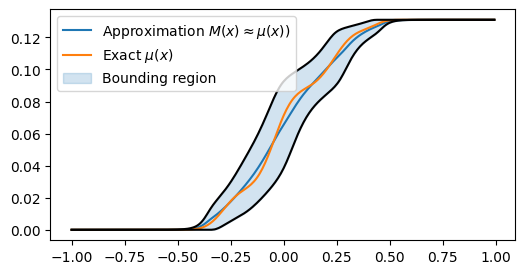

In [5]:
def plot_approximation_and_bounds(m: torch.Tensor, x: torch.Tensor, overestimation_weight: float, ax, with_legend: bool = True):
    # NOTE: `dm.compute_moment_bounds` expects m to have shape (2*n+1, B), where B is the number of evaluation points.
    #       Since we use the same moments for all evaluation points, they must be repeated to match the number of points.

    # The approximation is a weighted combination of the lower/upper bounds derived from the moments:
    L = dm.compute_moment_bounds(m[:, None].repeat((1, x.shape[0])), x, bias=0., overestimation_weight=0.)
    U = dm.compute_moment_bounds(m[:, None].repeat((1, x.shape[0])), x, bias=0., overestimation_weight=1.)

    M = dm.compute_moment_bounds(m[:, None].repeat((1, x.shape[0])), x, bias=0, overestimation_weight=overestimation_weight) # = (1-overestimation_weight) * L + overestimation_weight * U

    line = ax.plot(x.cpu(), M.cpu(), label=r'Approximation $M(x) \approx μ(x)$)')
    ax.plot(x.cpu(), μ_at_x, label='Exact $μ(x)$')
    ax.plot(x.cpu(), L.cpu(), color='black')
    ax.plot(x.cpu(), U.cpu(), color='black')
    ax.fill_between(x.cpu(), L.cpu(), U.cpu(), alpha=0.2, color=line[0].get_color(), label='Bounding region')
    if with_legend:
        ax.legend()

# The overestimation weight can be chosen freely in [0, 1]; 0.5 is halfway between the bounds.
overestimation_weight = 0.5

fig, ax = plt.subplots(1, 1, figsize=(6,3))
plot_approximation_and_bounds(m, x, overestimation_weight, ax=ax)

The sharpness of the bounds increases with $n$ (the number of moments) and the approximation becomes more accurate.

But, also be aware that higher $n$ decreases both, the reconstruction performance and the numerical stability.

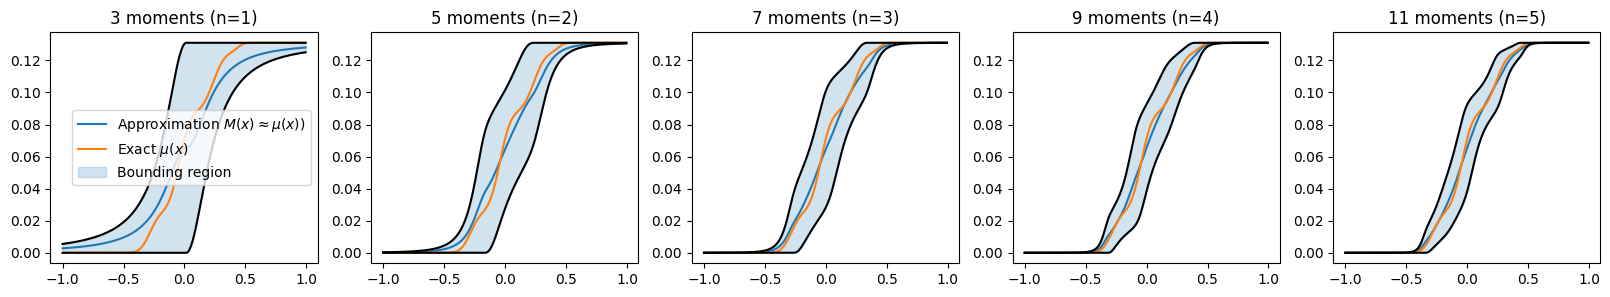

In [6]:
fig, ax = plt.subplots(1, n, figsize=(n*4,3))
for i in range(n):
    plot_approximation_and_bounds(m[:2*(i+1)+1], x, overestimation_weight, ax=ax[i], with_legend=i==0)
    ax[i].set_title(f"{2*(i+1)+1} moments (n={i+1})")

## Biasing and Error Detection

The reconstruction succeeds for a *positive* moment vector $\mathbf{m}$. Without going into too much detail, positivity can be violated, for example, if $f$ would be negative or due to numerical inaccuracy.

To avoid the latter case, it is advisable to apply a small amount of bias to the moment vector: $\mathbf{m} \leftarrow (1-\alpha) \mathbf{m} + \alpha \mathbf{m}^\star$. Think of it as pulling $\mathbf{m}$ slightly towards the bias vector $\mathbf{m}^\star$, where $\alpha \in [0, 1]$ is called the "bias".

Applying a bias, as the name suggests, biases the reconstruction, so we generally want the bias $\alpha$ to be small. However, if the bias is too small, the reconstruction might fail.

The bias vector $\mathbf{m}^\star$ is hardcoded internally and only the bias $\alpha$ is exposed as parameter. We provide a function `dm.default_bias(n)` that returns reasonable default biases but it's always worth investigating if a smaller bias is sufficient for the use case (sufficient = reconstruction succeeds).

Note that the bias vector $\mathbf{m}^\star$ depends on $n$ and is tuned for the range $[-1, 1]$ (see note above about normalization).

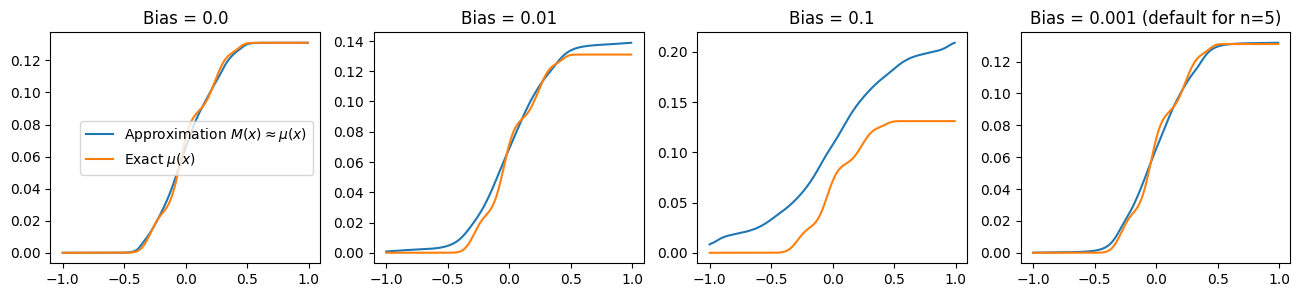

In [7]:
def plot_approximation_for_bias(m: torch.Tensor, bias: float, ax, with_legend: bool = True):
    M = dm.compute_moment_bounds(m[:, None].repeat((1, x.shape[0])), x, bias=bias, overestimation_weight=0.5)

    ax.plot(x, M, label=r'Approximation $M(x) \approx μ(x)$')
    ax.plot(x, μ_at_x, label='Exact $μ(x)$')
    if with_legend:
        ax.legend()

biases = [0.0, 0.01, 0.1, dm.default_bias(n)]
fig, axs = plt.subplots(1, len(biases), figsize=(4*len(biases),3))
for i, bias in enumerate(biases):
    plot_approximation_for_bias(m, bias, ax=axs[i], with_legend=i==0)
    axs[i].set_title(f"Bias = {bias}" + (f" (default for n={n})" if (i+1 == len(biases)) else ""))

If the reconstruction fails, `dm.compute_moment_bounds` returns `NaN` for the respective pair of moments and evaluation point.

In [8]:
# Create a list of moment vectors, one for each evaluation point in `x`
m_not_all_positive = m.clone()[:, None].repeat((1, x.shape[0]))

# Invalidate the 3rd moment vector (or the last one, if x has less than 3 elements)
invalidate_idx = min(2, x.shape[0]-1)
m_not_all_positive[:, invalidate_idx] *= 0 # A moment vector of all zeros is not positive.

M = dm.compute_moment_bounds(m_not_all_positive, x, bias=0., overestimation_weight=0.)

print("Any result invalid?", torch.isnan(M).any().item())

Any result invalid? True


Non-positivity is the most common cause of failure. 

However, if you are absolute certain that your moment vector is positive and you still encounter `NaN`s, the exact cause of failure can be queried using `dm.detect_bound_errors` (only use this function for debugging due to its performance impact).

If non-positivity is not the cause of the error, please open an issue on [GitHub](https://github.com/mworchel/differentiable-moment-bounds/issues) as this might indicate a bug.

In [9]:
try:
    dm.detect_bound_errors(M)
except RuntimeError as e:
    print(f"Error detected: {e}")

Error detected: Detected error for element 2: The Cholesky decomposition of the Hankel matrix failed because it is not positive definite (the moment sequence is not positive).


## Reverse-Mode Differentiation

The function `dm.compute_moment_bounds` supports reverse-mode differentiation for the moments $\mathbf{m}$ and the evaluation point $x$, so it can be used in gradient-based optimization.

In [10]:
m_attached = m.clone().requires_grad_(True)
x_attached = x.clone().requires_grad_(True)

M = dm.compute_moment_bounds(m_attached[:, None].repeat((1, x_attached.shape[0])), x_attached, bias=0, overestimation_weight=0.5)

# Not very meaningful loss
loss = M.mean()
loss.backward()

print("All moments have non-zero gradient?", torch.all(m_attached.grad != 0).item())
print("All evaluation points have non-zero gradient?", torch.all(x_attached.grad != 0).item())

All moments have non-zero gradient? True
All evaluation points have non-zero gradient? True


## CPU and GPU Inputs

All functions accept CPU/GPU inputs (the input arrays must be on the same device). 

Note that the GPU implementation uses CUDA, and currently only supports the default CUDA device (device 0). Multi-device support is on the roadmap.

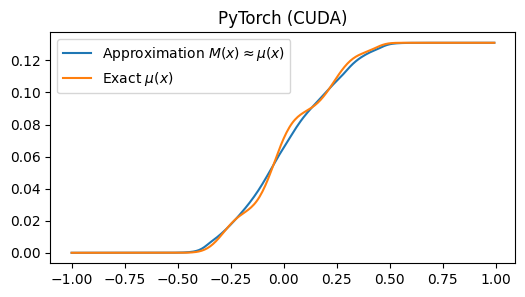

In [11]:
if torch.cuda.is_available():
    # For now, only device 0 is supported
    m_cuda = m.to(device='cuda:0')
    x_cuda = x.to(device='cuda:0')

    M = dm.compute_moment_bounds(m_cuda[:, None].repeat((1, x_cuda.shape[0])), x_cuda, bias=0, overestimation_weight=0.5)

    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax.set_title("PyTorch (CUDA)")
    ax.plot(x.cpu(), M.cpu(), label=r'Approximation $M(x) \approx μ(x)$')
    ax.plot(x.cpu(), μ_at_x, label='Exact $μ(x)$')
    ax.legend()
else:
    print("CUDA is not available on this machine.")    

## Interfaces for numpy and Dr.Jit

We have so far seen that the different functions accept PyTorch tensors on the CPU and the GPU.

The `diffmoment` package also provides interfaces for NumPy and [Dr.Jit](https://github.com/mitsuba-renderer/drjit) via respective subpackages.

Dr.Jit 'LLVM' backend is not available


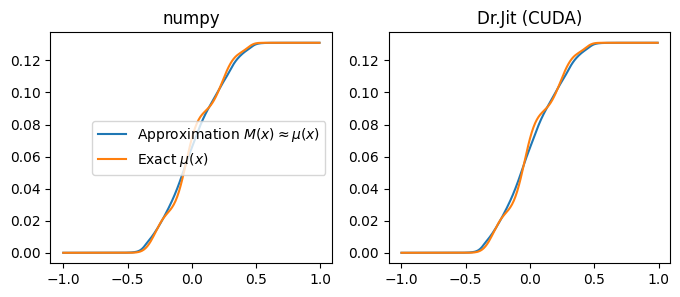

In [12]:
from typing import Iterable

outputs = []

# numpy
try:
    import numpy as np
    import diffmoments.np as dm_np # Do not overwrite the already imported `dm` package
    m_numpy = m.numpy()
    x_numpy = x.numpy()
    M_numpy = dm_np.compute_moment_bounds(np.repeat(m_numpy[:, None], x_numpy.shape[0], axis=1), x_numpy, bias=0, overestimation_weight=0.5)
    outputs.append(('numpy', M_numpy))
except Exception as e:
    print(e)

# drjit (LLVM and CUDA)
try:
    import drjit as dr
    import diffmoments.drjit as dm_dr # Do not overwrite the already imported `dm` package
    
    for (backend, Float, TensorXf) in [(dr.JitBackend.LLVM, dr.llvm.ad.Float, dr.llvm.ad.TensorXf), 
                                       (dr.JitBackend.CUDA, dr.cuda.ad.Float, dr.cuda.ad.TensorXf)]:
        if not dr.has_backend(backend):
            print(f"Dr.Jit '{backend.name}' backend is not available")
            continue

        m_drjit = TensorXf(m)
        x_drjit = Float(x)
        size = dr.width(x_drjit)
        M_drjit = dm_dr.compute_moment_bounds(dr.reshape(TensorXf, dr.repeat(m_drjit, size), (-1, size)), x_drjit, bias=0, overestimation_weight=0.5)
        outputs.append((f'Dr.Jit ({backend.name})', M_drjit.numpy()))
except Exception as e:
    print(e)

fig, axs = plt.subplots(1, len(outputs), figsize=(4*len(outputs),3))
if not isinstance(axs, Iterable):
    axs = [axs]

for i, (title, result) in enumerate(outputs):    
    axs[i].set_title(title)
    axs[i].plot(x, result, label=r'Approximation $M(x) \approx μ(x)$')
    axs[i].plot(x, μ_at_x, label='Exact $μ(x)$')
    if i == 0:
        axs[i].legend()